In [1]:
import numpy as np
import pandas as pd

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

glove-s50
news-of-the-site-folhauol



In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re, string, unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam

2024-06-07 14:42:09.072468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 14:42:09.072675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 14:42:09.279208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df=pd.read_csv("/kaggle/input/news-of-the-site-folhauol/articles.csv",encoding="utf8")
df.head(2)

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...


In [4]:
df.isna().sum()
df.dropna(subset=['text'], inplace=True)
df.drop_duplicates(subset=["text"],inplace=True)

In [5]:
df.isna().sum()
print(len(df))

165901


In [6]:
df.drop(columns=['link', 'subcategory', 'date'], inplace=True)
df.head()

,title,text,category
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,poder
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,poder
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


In [7]:
df['category'].value_counts()

category
poder                           22005
colunas                         21499
mercado                         20936
esporte                         19723
mundo                           17123
cotidiano                       16952
ilustrada                       15604
opiniao                          4523
paineldoleitor                   4008
saopaulo                         3953
tec                              2205
educacao                         2113
tv                               2065
turismo                          1902
ilustrissima                     1377
ciencia                          1331
equilibrioesaude                 1311
sobretudo                        1052
bbc                               979
folhinha                          875
empreendedorsocial                841
comida                            828
asmais                            547
ambiente                          490
seminariosfolha                   378
serafina                          331
o-m

In [8]:
top_categories = df['category'].value_counts().nlargest(7).index
df = df[df['category'].isin(top_categories)]

df['target'] = df['category'].replace('guia-de-livros-discos-filmes','guia-de-livros-filmes-discos')
alvo, valores = pd.factorize(df['target'],sort=True)
df['target'] = alvo
print('Novo tamanho:',len(df))
print(list(enumerate(valores)))


Novo tamanho: 133842
[(0, 'colunas'), (1, 'cotidiano'), (2, 'esporte'), (3, 'ilustrada'), (4, 'mercado'), (5, 'mundo'), (6, 'poder')]


In [9]:
stop = set(stopwords.words('portuguese'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [12]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

/tmp/ipykernel_33/3988634092.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


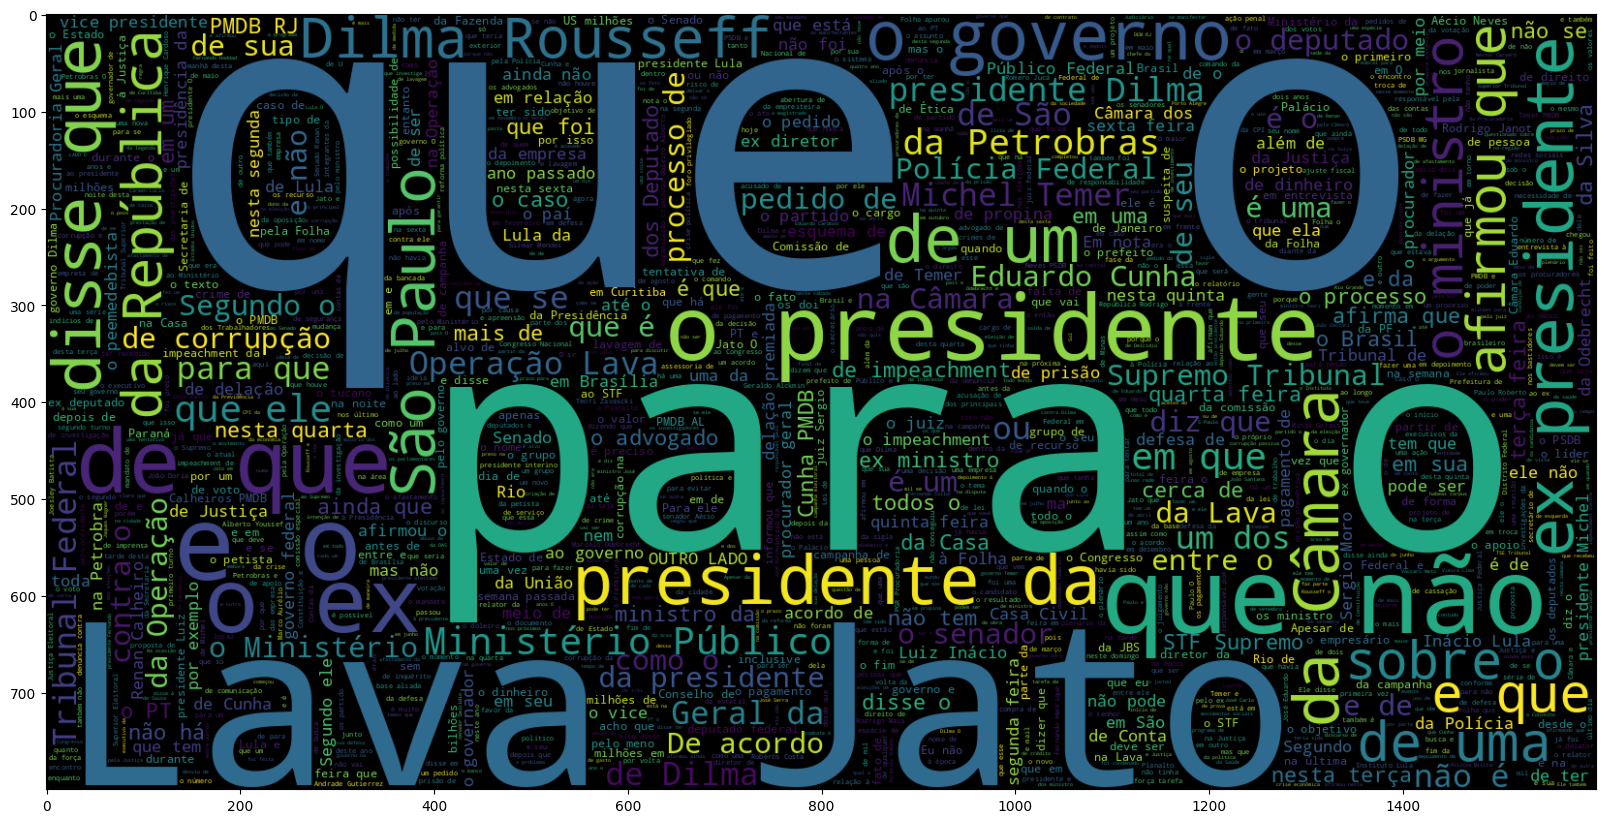

In [10]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df['category'] == 'poder'].text))
plt.imshow(wc , interpolation = 'bilinear')

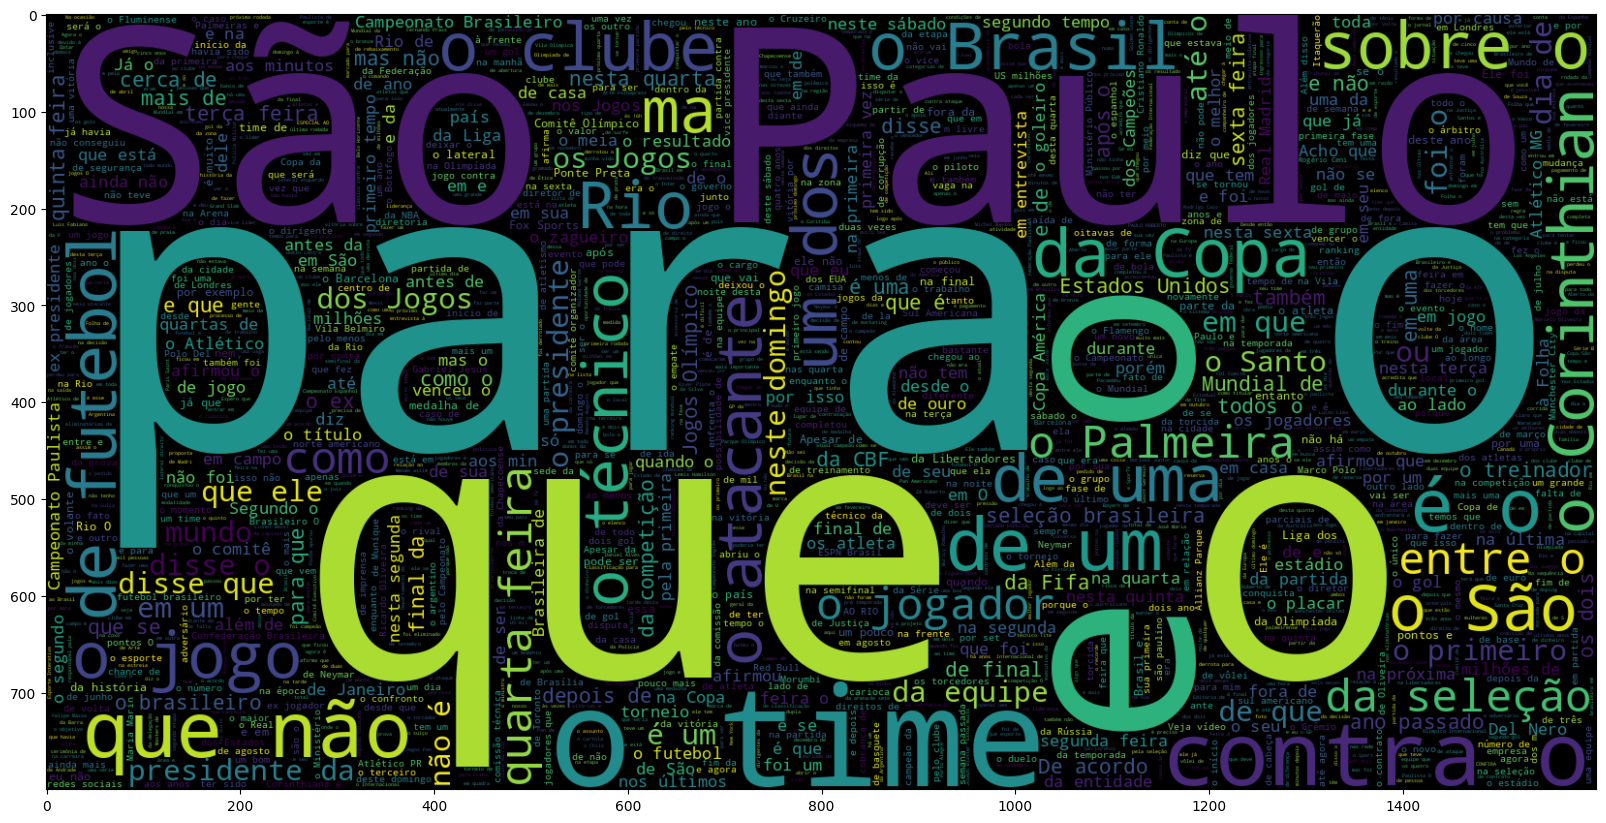

In [11]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df['category'] == 'esporte'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [45]:
import pandas as pd
#display(HTML('Carregando base em DataFrame(df_folha)'))
df_folha = df
#display(HTML('Removendo colunas desnecessárias: ["title","date","subcategory","link"]'))
#display(HTML(f'Linhas atuais: {len(df_folha)}'))
df_folha.drop_duplicates(subset=["text"],inplace=True)
df_folha.dropna(inplace=True)
df_folha.reset_index(drop=True,inplace=True)
#display(HTML(f'Linhas atualizadas: {len(df_folha)}'))
#display(HTML('Selecionando apenas as categorias relevantes para classificação'))
df_folha = df_folha[df_folha['category'].isin(list(df_folha['category'].value_counts()[:7].index))]

targets, class_names = pd.factorize(df_folha['category'],sort=True)

samples = df_folha['text'].values
labels = pd.get_dummies(targets,dtype='int').values

print('Categorias:',class_names)
df_folha.drop(["category"],axis=1,inplace=True)
df_folha['target'] = targets
df_folha.head()
del df_folha

Categorias: Index(['colunas', 'cotidiano', 'esporte', 'ilustrada', 'mercado', 'mundo',
       'poder'],
      dtype='object')


In [50]:
import numpy as np
# Misturando
#display(HTML('Misturando e separando dados para treinamento'))
rng = np.random.RandomState(42)
rng.shuffle(samples)
rng = np.random.RandomState(42) # faz a mesma mistura do anterior
rng.shuffle(labels)
# extraindo treinamento e validacao
parte_analisada = min(7000,len(samples)) # problemas de RAM
#display(HTML(f'Redução devido a RAM: {parte_analisada}'))
val_split = 0.2
val_num = int(val_split * parte_analisada)

samples_train = samples[:parte_analisada-val_num]
y_train = labels[:parte_analisada-val_num]

samples_val = samples[parte_analisada-val_num:parte_analisada]
y_val = labels[parte_analisada-val_num:parte_analisada]

#display(HTML(f'Treinamento: {samples_train.shape[0]} Validação {samples_val.shape[0]}'))

In [51]:
import tensorflow.data as tf_data
from tensorflow.keras import layers


dim_vetor = 200
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=dim_vetor)
text_ds = tf_data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)

vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'de', 'a', 'o']

In [52]:
output = vectorizer([["inteligência artificial dor de cabeça"]])
output.numpy()[0, :5]

array([1850, 7063, 2586,    2,  953])

In [53]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

test = ["inteligência", "artificial", "dor", "de", "cabeça"]
[word_index[w] for w in test]

[1850, 7063, 2586, 2, 953]

In [54]:
glove_file = '../input/glove-s50/glove_s50.txt'
embeddings_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

#display(HTML(f'Encontrado {len(embeddings_index)} vetores de palavras'))

/tmp/ipykernel_33/2919419078.py:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, "f", sep=" ")


In [55]:
num_tokens = len(voc) + 2
glove_vetor_tam = 50 # glove_s50 < 50
hits = 0
misses = 0
embedding_matrix = np.zeros((num_tokens, glove_vetor_tam))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector[:glove_vetor_tam]
        hits += 1
    else:
        misses += 1

#display(HTML(f'Convertidas {hits} palavras ({misses} perdidas)'))

In [56]:
from keras import layers

embedding_layer = layers.Embedding(num_tokens, glove_vetor_tam, trainable=False)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

#display(HTML('Camada com GloVe'))

In [57]:
import keras

int_sequences_input = keras.Input(shape=(dim_vetor,), dtype = "int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 200, 50)        │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 196, 128)       │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 39, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 35, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 3, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,739 (4.63 MB)

 Trainable params: 213,639 (834.53 KB)

 Non-trainable params: 1,000,100 (3.82 MB)

In [69]:

X_train = vectorizer(np.array([[s] for s in samples_train])).numpy()
X_val = vectorizer(np.array([[s] for s in samples_val])).numpy()

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

#display(HTML('Compilando Modelo Neural'))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])

#display(HTML('Treinando'))
epochs = 20
history = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_val, y_val))

(5600, 200) (5600, 7) (1400, 200) (1400, 7)
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - acc: 0.1958 - loss: 1.9724 - val_acc: 0.4193 - val_loss: 1.5037
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - acc: 0.4557 - loss: 1.4415 - val_acc: 0.4714 - val_loss: 1.5775
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - acc: 0.6106 - loss: 1.1166 - val_acc: 0.5864 - val_loss: 1.2144
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - acc: 0.6950 - loss: 0.8953 - val_acc: 0.6793 - val_loss: 0.9271
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - acc: 0.7472 - loss: 0.7782 - val_acc: 0.7336 - val_loss: 0.7482
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - acc: 0.7564 - loss: 0.7138 - val_acc: 0.7293 - val_loss: 0.7680
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - acc: 0.7886 - loss: 0.6338 - val_acc: 0.7307 - val_loss: 0.7863
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - acc: 0.7991 - loss: 0.6068 - val_acc: 0.7114 - val_loss: 0.9886
Epoch 9/20
4

Text(0.5, 1.0, 'Accuracy')

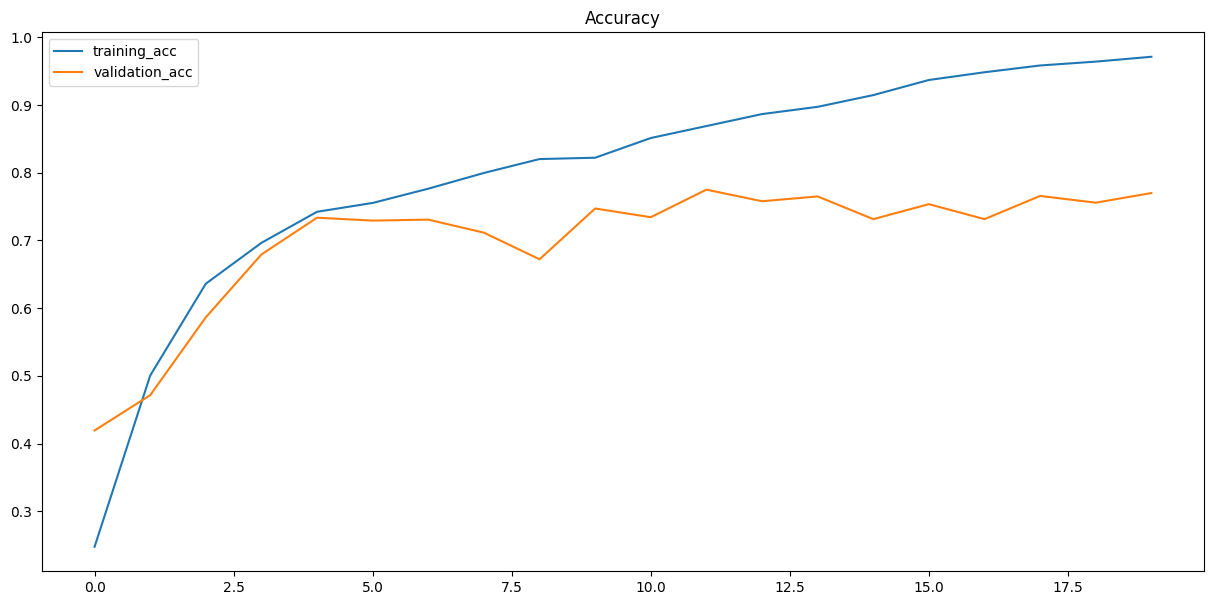

In [70]:
import matplotlib.pyplot as plt

#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['acc'])
plt.plot(range(epochs), history.history['val_acc'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [71]:
train_results = model.evaluate(X_train, np.asarray(y_train), verbose=0, batch_size=256)
test_results = model.evaluate(X_val, np.asarray(y_val), verbose=0, batch_size=256)
print(f'Train accuracy: {train_results[1]*100:0.2f}')
print(f'Test accuracy: {test_results[1]*100:0.2f}')

Train accuracy: 99.98
Test accuracy: 77.00


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


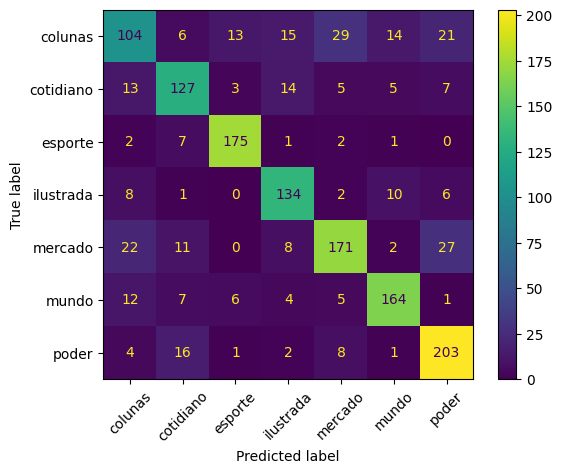

In [72]:

output_val = model.predict(X_val)
y_pred_val = output_val.argmax(1)
y_real_val = y_val.argmax(1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_real_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)